In [1]:
from carUtils import *
from linesUtils import *
from env import *

In [56]:
from collections import namedtuple, deque
from itertools import count
import random
import os
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Config

In [3]:
GAMMA=0.9
SEED=42
BATCH_SIZE=40
TARGET_UPDATE = 1

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)



criterion = nn.SmoothL1Loss()

env=Env()

In [4]:
def computeReward(env):
    """
    right now we are going to use a simple reward of the deviation from the line, well the negative of it
    """
    return -10*env.distance_from_track()+env.distance_from_start()-env.distance_from_end()

### Set up possible actions

In [5]:
possible_motor_percentages=[-60,60]
actions_to_MotorPer=np.empty((len(possible_motor_percentages)**2,2))
for i in range(len(possible_motor_percentages)):
    for j in range(len(possible_motor_percentages)):
        actions_to_MotorPer[i*len(possible_motor_percentages)+j]=[possible_motor_percentages[i],
                                                                 possible_motor_percentages[j]]
actions_to_MotorPer

array([[-60., -60.],
       [-60.,  60.],
       [ 60., -60.],
       [ 60.,  60.]])

## set up models

In [6]:
class DQN(nn.Module):
    def __init__(self, n_output_states):
        super(DQN, self).__init__()
        self.f1=nn.Linear(8,n_output_states)
        
    def forward(self,x):
        return self.f1(x)

In [7]:
def copy_params(policy_net,target_net):
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

In [8]:
n_actions=actions_to_MotorPer.shape[0]

policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
copy_params(policy_net,target_net)

optimizer = optim.RMSprop(policy_net.parameters())

In [9]:
def select_action(state,p_random=0.5):
    sample = np.random.random()
    if sample > p_random:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #print(policy_net(state))
            return torch.argmax(policy_net(state)).reshape((1,1))
    else:
        return torch.tensor([[np.random.randint(n_actions)]], device=device, dtype=torch.long)

### Memory

In [10]:
class Memory:
    def __init__(self,max_size=1000):
        self.states=[]
        self.next_states=[]
        self.rewards=[]
        self.actions=[]
        self.max_size=max_size
        
    def push(self,state,action,next_state,reward):
        
        if len(self)==self.max_size:
            self.states=[]
            self.next_states=[]
            self.rewards=[]
            self.actions=[]
        self.states.append(state)
        self.next_states.append(next_state)
        self.rewards.append(reward)
        self.actions.append(action)
        
    def sample(self,n_samples):
        paired=list(zip(self.states, self.next_states, self.rewards,self.actions))
        states,next_states,rewards,actions=zip(*random.sample(paired, n_samples))
        
        states=torch.stack(states).to(device)
#         next_states=torch.stack(next_states).to(device)
        rewards=torch.stack(rewards).to(device)
        #print(rewards.shape)
        actions=torch.stack(actions).to(device).squeeze((-1))
#         print(actions.shape)
        return states,next_states,rewards,actions
        
    def __len__(self):
        return len(self.states)

memory=Memory()

In [11]:
def optimize_model():
    
    if len(memory) < BATCH_SIZE:
        return
    #print("optimizing")
    states,next_states,rewards,actions = memory.sample(BATCH_SIZE)
    
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          next_states)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in next_states
                                                if s is not None])


    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
#     print(states.shape)
#     print(actions.shape)
    state_action_values = policy_net(states).gather(1, actions)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    #print(non_final_next_states.shape)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values

    expected_state_action_values = (next_state_values * GAMMA) + rewards.squeeze(-1)

    # Compute Huber loss
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    

In [12]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    state = torch.tensor(env.move_car(0,0), device=device,
                                     dtype=torch.float)
    next_state = torch.tensor(env.move_car(0,0), device=device,
                                     dtype=torch.float)
    max_t=4000
    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_state = torch.tensor(env.move_car(*actions_to_MotorPer[action.item()]), device=device,
                                     dtype=torch.float)
        
        #check if too far off track
        done=env.off_track() or t>max_t
        #check distance and compute reward
        reward = torch.tensor([computeReward(env)], device=device)
        
        if done:
            next_state = None

        # Store the transition in memory
#         print("state")
#         print(state)
#         print("action")
#         print(action)
#         print("next_state")
#         print(next_state)
#         print("reward")
#         print(reward)
#         print("------------------------------")
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state
        #print(f"carX={env.car.X}, carY={env.car.Y}, t={t}")
        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            print("breaking")
            break
            
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking
breaking


KeyboardInterrupt: 

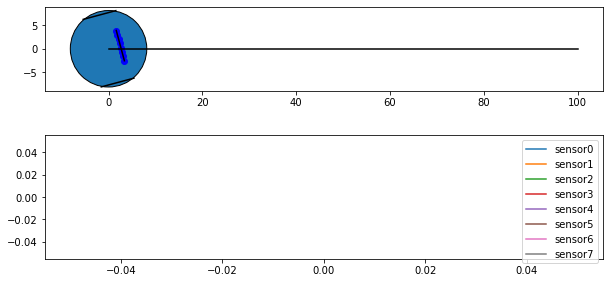

In [91]:
env.reset()
env.car.set_loc(0,0,15)
env.plot()


#os.mkdir("testImgs2")

In [92]:
state=torch.tensor(env.move_car(0,0), device=device,
                                     dtype=torch.float)

In [93]:
with torch.no_grad():
    for i in tqdm.tqdm(range(40000)):
        action = select_action(state,p_random=0)
        #print(f"carX={env.car.X}, carY={env.car.Y}")
        state = torch.tensor(env.move_car(*actions_to_MotorPer[action.item()]), device=device,
                                     dtype=torch.float)
        
        if i%100==0:
            env.plot("testImgs2",f"{i}.png")

100%|████████████████████████████████████| 40000/40000 [02:56<00:00, 226.19it/s]


In [74]:
import glob
from PIL import Image




In [86]:
#files=glob.glob(f"testImgs3/*.png")

In [94]:
images=[]
for i in tqdm.tqdm(range(40000)):
    if i%1000==0:
        images.append(Image.open(f"testImgs2/{i}.png"))

100%|████████████████████████████████| 40000/40000 [00:00<00:00, 2798161.38it/s]


In [95]:
frame_one = images[0]
frame_one.save("my_awesome3.gif", format="GIF", append_images=images,
           save_all=True, duration=100, loop=0)

In [81]:
torch.save(policy_net.state_dict(),"veryGoodModel!.pt")